# Importing Cleaned Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv("output.csv")
dates = pd.to_datetime(data["Date"])
dates = dates[7:]
dates

7      1988-08-10
8      1988-08-11
9      1988-08-12
10     1988-08-15
11     1988-08-16
          ...    
9009   2023-08-23
9010   2023-08-24
9011   2023-08-25
9012   2023-08-27
9013   2023-08-28
Name: Date, Length: 9007, dtype: datetime64[ns]

# Setting Device to GPU

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
#plt.plot(data['Date'], data['Price'])

# Formatting for LSTM

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Price(t-{i})'] = df['Price'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7)
Date,,,,,,,,
1988-08-10,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680,0.8600,0.8655
1988-08-11,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680,0.8600
1988-08-12,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680
1988-08-15,0.8880,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780
1988-08-16,0.8880,0.8880,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870
...,...,...,...,...,...,...,...,...
2023-08-23,3.8375,3.7885,3.7185,3.7060,3.6915,3.6575,3.6675,3.7255
2023-08-24,3.7935,3.8375,3.7885,3.7185,3.7060,3.6915,3.6575,3.6675
2023-08-25,3.7840,3.7935,3.8375,3.7885,3.7185,3.7060,3.6915,3.6575


In [6]:
shifted_df_as_np_before_scaling = shifted_df.to_numpy()

In [7]:
shifted_df_as_np_before_scaling

array([[0.8875, 0.876 , 0.871 , ..., 0.868 , 0.86  , 0.8655],
       [0.901 , 0.8875, 0.876 , ..., 0.878 , 0.868 , 0.86  ],
       [0.8835, 0.901 , 0.8875, ..., 0.887 , 0.878 , 0.868 ],
       ...,
       [3.784 , 3.7935, 3.8375, ..., 3.706 , 3.6915, 3.6575],
       [3.8027, 3.784 , 3.7935, ..., 3.7185, 3.706 , 3.6915],
       [3.788 , 3.8027, 3.784 , ..., 3.7885, 3.7185, 3.706 ]])

In [8]:
#%pip install sklearn

# Scaling Data

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

shifted_df_as_np = scaler.fit_transform(shifted_df_as_np_before_scaling)

shifted_df_as_np

array([[-0.64423604, -0.64890486, -0.65093478, ..., -0.65215273,
        -0.6554006 , -0.65316769],
       [-0.63875525, -0.64423604, -0.64890486, ..., -0.64809289,
        -0.65215273, -0.6554006 ],
       [-0.64585998, -0.63875525, -0.64423604, ..., -0.64443903,
        -0.64809289, -0.65215273],
       ...,
       [ 0.53169722,  0.53555407,  0.55341737, ...,  0.50003045,
         0.49414368,  0.48034021],
       [ 0.53928912,  0.53169722,  0.53555407, ...,  0.50510525,
         0.50003045,  0.49414368],
       [ 0.53332115,  0.53928912,  0.53169722, ...,  0.53352415,
         0.50510525,  0.50003045]])

In [10]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((9007, 7), (9007,))

In [11]:
X = dc(np.flip(X, axis=1))
X

array([[-0.65316769, -0.6554006 , -0.65215273, ..., -0.64443903,
        -0.65093478, -0.64890486],
       [-0.6554006 , -0.65215273, -0.64809289, ..., -0.65093478,
        -0.64890486, -0.64423604],
       [-0.65215273, -0.64809289, -0.64443903, ..., -0.64890486,
        -0.64423604, -0.63875525],
       ...,
       [ 0.48034021,  0.49414368,  0.50003045, ...,  0.53352415,
         0.55341737,  0.53555407],
       [ 0.49414368,  0.50003045,  0.50510525, ...,  0.55341737,
         0.53555407,  0.53169722],
       [ 0.50003045,  0.50510525,  0.53352415, ...,  0.53555407,
         0.53169722,  0.53928912]])

# Splitting to Traing Set and Testing Set 

In [12]:
split_index = int(len(X) * 0.80)

split_index
split_date = dates[split_index]
split_date

Timestamp('2016-09-23 00:00:00')

In [13]:
X_train = X[:split_index]
X_test = X[split_index:]
train_dates = dates[:split_index]
test_dates = dates[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
test_dates.shape

X_train
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

array([[-0.65316769, -0.6554006 , -0.65215273, ..., -0.64443903,
        -0.65093478, -0.64890486],
       [-0.6554006 , -0.65215273, -0.64809289, ..., -0.65093478,
        -0.64890486, -0.64423604],
       [-0.65215273, -0.64809289, -0.64443903, ..., -0.64890486,
        -0.64423604, -0.63875525],
       ...,
       [-0.12701216, -0.13127499, -0.11442665, ..., -0.1132087 ,
        -0.12457625, -0.11767452],
       [-0.13127499, -0.11442665, -0.11239673, ..., -0.12457625,
        -0.11767452, -0.11544161],
       [-0.11442665, -0.11239673, -0.1132087 , ..., -0.11767452,
        -0.11544161, -0.10711893]])

In [14]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
  # Ensure all elements are displayed
#print(X_train)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([7205, 7, 1]),
 torch.Size([1802, 7, 1]),
 torch.Size([7205, 1]),
 torch.Size([1802, 1]))

# Preparing LSTM

In [16]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [17]:
train_dataset[0]

(tensor([[-0.6532],
         [-0.6554],
         [-0.6522],
         [-0.6481],
         [-0.6444],
         [-0.6509],
         [-0.6489]]),
 tensor([-0.6442]))

In [18]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

# Training and Optimising

In [21]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [22]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [23]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
"""
Adam does the gradient descent for me
"""
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.085
Batch 200, Loss: 0.006
Batch 300, Loss: 0.002
Batch 400, Loss: 0.001

Val Loss: 0.006
***************************************************

Epoch: 2
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Val Loss: 0.003
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000
Batch 400, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.000

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.001

Val Loss: 0.001
****************************

# Results

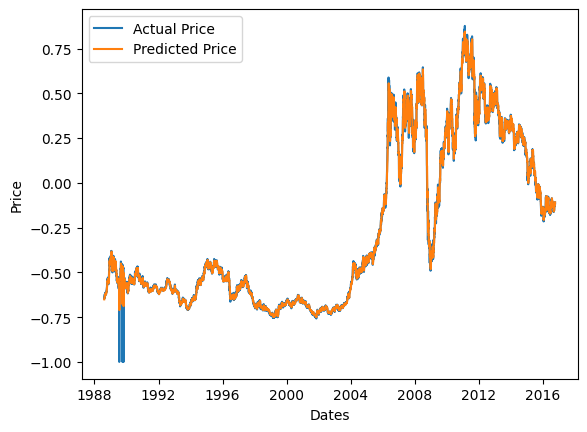

In [24]:
with torch.no_grad():
    predicted = model(X_train[:].to(device)).to('cpu').numpy()

plt.plot(train_dates,y_train, label='Actual Price')
plt.plot(train_dates,predicted, label='Predicted Price')

plt.xlabel('Dates')
plt.ylabel('Price')
plt.legend()
plt.show()


In [25]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([0.87192117, 0.87686341, 0.88523349, ..., 2.18843452, 2.19293529,
       2.20615258])

In [26]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_train = dc(dummies[:, 0])
new_y_train

array([0.88750003, 0.90099998, 0.88350005, ..., 2.18999999, 2.2105    ,
       2.192     ])

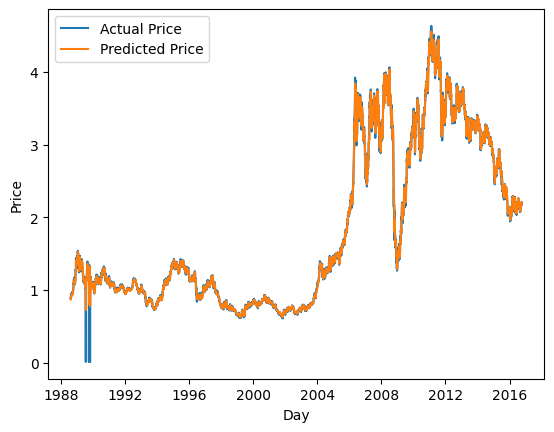

In [27]:
plt.plot(train_dates,new_y_train,  label='Actual Price')
plt.plot(train_dates,train_predictions, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([2.2015471 , 2.18616993, 2.1782657 , ..., 3.79809293, 3.7895477 ,
       3.7977648 ])

In [29]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test
squared_differences = (new_y_test - test_predictions)**2

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(squared_differences))
#rmse
absolute_differences = np.abs(new_y_test - test_predictions)

# Calculate the Mean Absolute Error (MAE)
mae = np.mean(absolute_differences)
rmse

0.05237175520456289

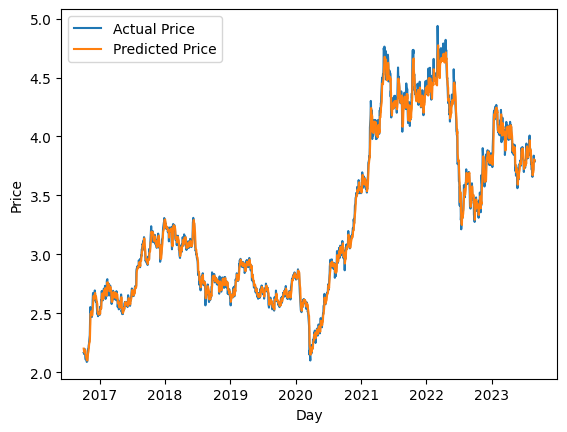

In [30]:
plt.plot(test_dates, new_y_test, label='Actual Price')
plt.plot(test_dates,test_predictions, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()


In [31]:
test_dates

7212   2016-10-04
7213   2016-10-05
7214   2016-10-06
7215   2016-10-07
7216   2016-10-10
          ...    
9009   2023-08-23
9010   2023-08-24
9011   2023-08-25
9012   2023-08-27
9013   2023-08-28
Name: Date, Length: 1802, dtype: datetime64[ns]